## Final Model Pipeline
After various iterations of model tuning, feature engineering/selection, and performance analysis, we have settled on the final set of features and parameters we'd like to use for our **Random Forest** model.

One thing we wish we could have done more is an exhaustive hyper parameter tuning, but for now we role with the best that we've seen through our research/ journey.

### Goal 
Build a final model pipeline and evaluate our final model on train, validation, and test.

### Package Imports

In [0]:
import numpy as np
import pandas as pd
import plotly as px
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from datetime import datetime
import time

import pyspark.sql.functions as f
import pyspark.sql.types as t
from pyspark.sql.functions import isnan, when, count, col

from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler, StandardScaler, OneHotEncoder, SQLTransformer
from pyspark.ml.classification import LogisticRegression 
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.sql import Window

from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import mlflow
import mlflow.spark

import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

### Load in Data
Already split into train, validation, and test

In [0]:
train_data = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/team20SSDK/project_data/train/part-00*.parquet")
val_data = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/team20SSDK/project_data/validation/part-00*.parquet")
test_data = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/team20SSDK/project_data/test/part-00*.parquet")

print("Train Data: ", train_data.count())
print("Validation Data: ", val_data.count())
print("Test Data: ", test_data.count())

Train Data: 16828952
Validation Data: 7071462
Test Data: 7270785

### Helper Functions
Auxillary functions for use in the pipeline

In [0]:
#Returns a Pandas DF with top features and scores based on the input RF model
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [0]:
#Helper function to check and create a path if it doesn't exist already
def path_exists(path):
    print("Path: ", path)
    try:
        dbutils.fs.ls(path)
        return True
    except Exception as e:
        dbutils.fs.mkdirs(path)        
        return False

### NEW FEATURE

##### IS_EARLY_MORN_FLIGHT

For our business case, we would like to be more conservative in terms of predicting delay. i.e. In all cases we would prefer telling a customer that there is no delay, evven if there ends up being one.

Therefore we want to minimize **False Positives (FP)**. When performing this analysis on our latest models the following [notebook] we found that there is a spike in **FP**'s for early morning flights, i.e. when `MINUTES_AFTER_MIDNIGHT_ORIGIN` is less than **180**. To address this pitfall, we are adding a special boolean term, that indicates whether or not the flight is an early morning flight.

By including this feature, we hope to give the Random Forest another viable split point to distinguish these scenarios


**Note: `MINUTES_AFTER_MIDNIGHT_ORIGIN` and `MINUTES_AFTER_MIDNIGHT_DEST` are calculated in UTC time.**

[notebook]: https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/2834511320022313/command/2834511320025772

In [0]:
train_data = train_data.withColumn("IS_EARLY_MORNING_FLIGHT", when(f.col("MINUTES_AFTER_MIDNIGHT_ORIGIN") <= 180,1).otherwise(0))
val_data = val_data.withColumn("IS_EARLY_MORNING_FLIGHT", when(f.col("MINUTES_AFTER_MIDNIGHT_ORIGIN") <= 180,1).otherwise(0))
test_data = test_data.withColumn("IS_EARLY_MORNING_FLIGHT", when(f.col("MINUTES_AFTER_MIDNIGHT_ORIGIN") <= 180,1).otherwise(0))

#### Final Features

In [0]:
final_features = ['DELAYS_SO_FAR','MINUTES_AFTER_MIDNIGHT_ORIGIN','MINUTES_AFTER_MIDNIGHT_DEST', 
            'NETWORK_CONGESTION','AVG_VIS_DIS_ORIGIN','DEST_PR','ORIGIN_PR', 'AVG_DEW_DEG_ORIGIN',
            'CRS_ELAPSED_TIME', 'AVG_WND_SPEED_ORIGIN','AVG_WND_SPEED_DEST','QUARTER',
            'IS_EARLY_MORNING_FLIGHT','DEP_HOUR_BIN','ARR_HOUR_BIN']

label_col = ['DEP_DEL15']
final_cols = list(set(final_features + label_col))

print("Number of features: ", len(final_features))
print(final_cols)

Number of features: 15
['NETWORK_CONGESTION', 'DEP_DEL15', 'DELAYS_SO_FAR', 'ORIGIN_PR', 'AVG_WND_SPEED_ORIGIN', 'ARR_HOUR_BIN', 'AVG_WND_SPEED_DEST', 'MINUTES_AFTER_MIDNIGHT_ORIGIN', 'DEST_PR', 'IS_EARLY_MORNING_FLIGHT', 'AVG_VIS_DIS_ORIGIN', 'MINUTES_AFTER_MIDNIGHT_DEST', 'AVG_DEW_DEG_ORIGIN', 'CRS_ELAPSED_TIME', 'DEP_HOUR_BIN', 'QUARTER']

In [0]:
#Keep on Train
train_final = train_data.select(*final_cols)

#Keep on Val
val_final = val_data.select(*final_cols)

#Keep on Val
test_final = test_data.select(*final_cols)

print("Remaining Col Count: ", len(train_final.columns))
test_final.printSchema()

Remaining Col Count: 16
root
-- NETWORK_CONGESTION: double (nullable = true)
-- DEP_DEL15: double (nullable = true)
-- DELAYS_SO_FAR: double (nullable = true)
-- ORIGIN_PR: double (nullable = true)
-- AVG_WND_SPEED_ORIGIN: double (nullable = true)
-- ARR_HOUR_BIN: integer (nullable = true)
-- AVG_WND_SPEED_DEST: double (nullable = true)
-- MINUTES_AFTER_MIDNIGHT_ORIGIN: integer (nullable = true)
-- DEST_PR: double (nullable = true)
-- IS_EARLY_MORNING_FLIGHT: integer (nullable = false)
-- AVG_VIS_DIS_ORIGIN: double (nullable = true)
-- MINUTES_AFTER_MIDNIGHT_DEST: integer (nullable = true)
-- AVG_DEW_DEG_ORIGIN: double (nullable = true)
-- CRS_ELAPSED_TIME: double (nullable = true)
-- DEP_HOUR_BIN: integer (nullable = true)
-- QUARTER: integer (nullable = true)

In [0]:
cat_cols = ['QUARTER', 'IS_EARLY_MORNING_FLIGHT',
            'DEP_HOUR_BIN','ARR_HOUR_BIN']

num_cols = ['DELAYS_SO_FAR','MINUTES_AFTER_MIDNIGHT_ORIGIN',
            'MINUTES_AFTER_MIDNIGHT_DEST', 'NETWORK_CONGESTION',
            'AVG_VIS_DIS_ORIGIN','DEST_PR','ORIGIN_PR','AVG_DEW_DEG_ORIGIN',
            'CRS_ELAPSED_TIME', 'AVG_WND_SPEED_ORIGIN',
            'AVG_WND_SPEED_DEST']

### Apply Balance Ratio
Compute the balance ratio only from training data

In [0]:
balancing_ratio = train_final.filter("DEP_DEL15 == 0").count() / train_final.count()
print("Balancing Ratio =", balancing_ratio)

Balancing Ratio = 0.8213681992794323

In [0]:
train_final = train_final.withColumn("CLASS_WEIGHTS", when(train_final.DEP_DEL15 == 1, balancing_ratio) \
                               .otherwise(1 - balancing_ratio))

val_final = val_final.withColumn("CLASS_WEIGHTS", when(val_final.DEP_DEL15 == 1, balancing_ratio) \
                               .otherwise(1 - balancing_ratio))

test_final = test_final.withColumn("CLASS_WEIGHTS", when(test_final.DEP_DEL15 == 1, balancing_ratio) \
                               .otherwise(1 - balancing_ratio))

In [0]:
cols = list(set(cat_cols + num_cols + label_col)) + ["CLASS_WEIGHTS"]
train = train_final.select(*cols).withColumnRenamed('DEP_DEL15', 'label')
val = val_final.select(*cols).withColumnRenamed('DEP_DEL15', 'label')
test = test_final.select(*cols).withColumnRenamed('DEP_DEL15', 'label')

print((train.count(), len(train.columns)))
print((val.count(), len(val.columns)))
print((test.count(), len(test.columns)))
display(test)

(16828952, 17)
(7071462, 17)
(7270785, 17)

NETWORK_CONGESTION,label,DELAYS_SO_FAR,ORIGIN_PR,ARR_HOUR_BIN,AVG_WND_SPEED_ORIGIN,AVG_WND_SPEED_DEST,MINUTES_AFTER_MIDNIGHT_ORIGIN,DEST_PR,IS_EARLY_MORNING_FLIGHT,AVG_VIS_DIS_ORIGIN,MINUTES_AFTER_MIDNIGHT_DEST,AVG_DEW_DEG_ORIGIN,CRS_ELAPSED_TIME,DEP_HOUR_BIN,QUARTER,CLASS_WEIGHTS
1390.0,0.0,0.0,5.289432718426684E-4,2,31.0,26.0,941,0.05675633205934823,0,16093.0,1023,255.0,82.0,2,3,0.17863180072056772
981.0,0.0,0.0,5.289432718426684E-4,2,0.0,31.0,1005,0.05675633205934823,0,16093.0,1084,130.0,79.0,2,1,0.17863180072056772
532.0,0.0,0.0,5.289432718426684E-4,2,31.0,0.0,946,0.05675633205934823,0,16093.0,1024,152.0,78.0,2,2,0.17863180072056772
2459.0,0.0,0.0,5.289432718426684E-4,2,41.0,31.0,966,0.05675633205934823,0,16093.0,1044,241.0,78.0,2,3,0.17863180072056772
1097.0,1.0,0.0,5.289432718426684E-4,2,15.0,41.0,968,0.05675633205934823,0,16093.0,1050,232.0,82.0,2,4,0.8213681992794323
1479.0,0.0,0.0,5.289432718426684E-4,2,67.0,57.0,1025,0.05675633205934823,0,16093.0,1104,-2.0,79.0,2,4,0.17863180072056772
1473.0,0.0,0.0,5.289432718426684E-4,3,36.0,36.0,1304,0.05675633205934823,0,16093.0,1387,102.0,83.0,3,4,0.17863180072056772
916.0,1.0,2.0,0.0012144228110371794,2,31.0,67.0,1007,0.011473750629657485,0,16093.0,1139,-78.0,132.0,2,1,0.8213681992794323
1333.0,0.0,0.0,0.0012144228110371794,3,21.0,36.0,1245,0.022271477655767678,0,16093.0,1365,160.0,120.0,2,1,0.17863180072056772
1778.0,0.0,0.0,0.0012144228110371794,1,62.0,67.0,784,0.03817081837439715,0,16093.0,924,155.0,140.0,1,1,0.17863180072056772


### Model Pipeline

The following pipeline provides the necessary steps to 
* Pre Proces Data 
  * one hot encoding for categorical variable, 
  * assemble feature vectors
* Load/Train a Random Forest model
* Evaluate the Model
* Store the Model

In [0]:
col_vec_out = [x+'_catVec' for x in cat_cols]

#StringIndex into labelled indices
indexers = [StringIndexer(inputCol=x, outputCol= x+'_tmp') for x in cat_cols]

#OneHotEncoder, indices into sparse one hot encoded columns
encoders = [OneHotEncoder(dropLast=False, inputCol=x+'_tmp', outputCol=y) for x,y in zip(cat_cols, col_vec_out)]

#Create pair of zips
stages = [[i,j] for i,j in zip(indexers, encoders)]

#Flatten into stages
stages = [stage for sublist in stages for stage in sublist]

#Assemble all the features together into one feature vector
res_cols = num_cols + col_vec_out
vector_assembler = VectorAssembler(inputCols=res_cols, outputCol="features", handleInvalid='skip')
stages += [vector_assembler]

In [0]:
%%time

model_version = "rf_model_final"
nTree = 50
mDep = 18
subSamp = 1.0

# Explicitly create a new run.
# This allows this cell to be run multiple times.
# If you omit mlflow.start_run(), then this cell could run once, but a second run would hit conflicts when attempting to overwrite the first run.
with mlflow.start_run():

    start = time.time()
    pipeline = Pipeline().setStages(stages)
  
    #MISLEADING - No model fitting is happening here. Just creating the 1 hot encoded columns
    train_pip = pipeline.fit(train).transform(train)
    val_pip = pipeline.fit(val).transform(val)
    test_pip = pipeline.fit(test).transform(test)    
    done = time.time()
    mlflow.log_metric('pip_fit_time' ,done - start)

    rf = RandomForestClassifier(labelCol="label", featuresCol="features", weightCol="CLASS_WEIGHTS",
                            numTrees=nTree, maxDepth=mDep, cacheNodeIds = True, subsamplingRate = subSamp)  
    mlflow.log_param('numTrees', nTree)
    mlflow.log_param('maxDepth', mDep)
    mlflow.log_param('cacheNodeIds', True)
    mlflow.log_param('subsamplingRate', subSamp)  

    start = time.time()
    rf_model = rf.fit(train_pip)
    done = time.time()
    mlflow.log_metric('model_fit_time' ,done - start)

    start = time.time()
    train_results = rf_model.transform(train_pip)
    done = time.time()
    mlflow.log_metric('train_pred_time' ,done - start)  

    start = time.time()
    val_results = rf_model.transform(val_pip)
    done = time.time()
    mlflow.log_metric('val_pred_time' ,done - start)
    
    start = time.time()
    test_results = rf_model.transform(test_pip)
    done = time.time()
    mlflow.log_metric('test_pred_time' ,done - start)    

    #Set up BinClassEval
    evaluator = BinaryClassificationEvaluator()
    evaluator.setRawPredictionCol("raw")

    trainScoreAndLabels = train_results.select(['probability','label', f.col("prediction").alias("raw")])
    valScoreAndLabels = val_results.select(['probability','label', f.col("prediction").alias("raw")])
    testScoreAndLabels = test_results.select(['probability','label', f.col("prediction").alias("raw")])    

    print("Train Set")
    start=time.time()
    train_pr = evaluator.evaluate(trainScoreAndLabels, {evaluator.metricName: "areaUnderPR"})
    train_roc = evaluator.evaluate(trainScoreAndLabels, {evaluator.metricName: "areaUnderROC"})
    done = time.time()
    mlflow.log_metric('train_metric_time' ,done - start)  

    print("train areaUnderPR: ", train_pr)
    print("train areaUnderROC: ", train_roc)
    mlflow.log_metric('train_pr' ,train_pr)
    mlflow.log_metric('train_roc' ,train_roc)
    print()

    print("Validation Set")
    start =time.time()
    val_pr = evaluator.evaluate(valScoreAndLabels, {evaluator.metricName: "areaUnderPR"})
    val_roc = evaluator.evaluate(valScoreAndLabels, {evaluator.metricName: "areaUnderROC"})
    done = time.time()
    mlflow.log_metric('val_metric_time' ,done - start)    

    print("val areaUnderPR: ", val_pr)
    print("val areaUnderROC: ", val_roc)
    mlflow.log_metric('val_pr' , val_pr)
    mlflow.log_metric('val_roc' ,val_roc)
    
    
    print("Test Set")
    start =time.time()
    test_pr = evaluator.evaluate(testScoreAndLabels, {evaluator.metricName: "areaUnderPR"})
    test_roc = evaluator.evaluate(testScoreAndLabels, {evaluator.metricName: "areaUnderROC"})
    done = time.time()
    mlflow.log_metric('test_metric_time' ,done - start)    

    print("test areaUnderPR: ", test_pr)
    print("test areaUnderROC: ", test_roc)
    mlflow.log_metric('test_pr' , test_pr)
    mlflow.log_metric('test_roc' ,test_roc)      

    # Log this model.
    mlflow.spark.log_model(spark_model=rf_model, artifact_path=model_version)

    start =time.time()
    #Save the model out in case we need to reference again in the future
    rf_model.write().overwrite().save(f"dbfs:/mnt/mids-w261/team20SSDK/models/{model_version}")
    done = time.time()
    mlflow.log_metric('model_save_time' ,done - start)     

    start =time.time()
    #m3_train_results input is just used for Schema purposes
    varlist = ExtractFeatureImp(rf_model.featureImportances, test_results, "features")
    varlist["order"] = np.arange(1, len(varlist["idx"])+1)
    done = time.time()
    mlflow.log_metric('extract_feat_imp_time' ,done - start)   

    start =time.time()
    #Log these artifacts for graphs and charts later on
    trainScoreAndLabels_pd = trainScoreAndLabels.toPandas()
    valScoreAndLabels_pd = valScoreAndLabels.toPandas()
    testScoreAndLabels_pd = testScoreAndLabels.toPandas()    
    
    #Create Path if it doesn't exist
    path_exists(f'dbfs:/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}')
    
    #Extract it all to evaluate later on.
    varlist.to_csv(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/feat_imp.csv', index=False)
    valScoreAndLabels_pd.to_csv(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/val_pred.csv', index=False)
    trainScoreAndLabels_pd.to_csv(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/train_pred.csv',index=False)
    testScoreAndLabels_pd.to_csv(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/test_pred.csv',index=False)    
    done = time.time()
    mlflow.log_metric('ouput_to_pd_time' , done - start)
    
    # Log the saved table as an artifact
    mlflow.log_artifact(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/feat_imp.csv')
    mlflow.log_artifact(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/val_pred.csv')
    mlflow.log_artifact(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/train_pred.csv')
    mlflow.log_artifact(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/test_pred.csv')    
  

Train Set
train areaUnderPR: 0.34102914323354794
train areaUnderROC: 0.7121428149509785

Validation Set
val areaUnderPR: 0.3282700982250578
val areaUnderROC: 0.677815512397747
Test Set
test areaUnderPR: 0.32624500700494297
test areaUnderROC: 0.6707949268143322
/databricks/spark/python/pyspark/sql/pandas/conversion.py:93: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field probability. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Context: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)
Path: dbfs:/mnt/mids-w261/team20SSDK/models/model_meta/rf_model_final
CPU times: user 11min 19s, sys: 55.1 s, total: 12min 14s
Wall time: 3h 11min 56s

### Model Output Analysis

In [0]:
#Bring in all of the model outputs

model_version = 'rf_model_final'
feat_imp = pd.read_csv(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/feat_imp.csv')
valScoreAndLabels_pd = pd.read_csv(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/val_pred.csv')
trainScoreAndLabels_pd = pd.read_csv(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/train_pred.csv')
testScoreAndLabels_pd = pd.read_csv(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/test_pred.csv')

#### Feature Importance Rankings

In [0]:
feat_imp.head(30)

Out[17]:

,idx,name,score,order
0,0,DELAYS_SO_FAR,0.384851,1
1,2,MINUTES_AFTER_MIDNIGHT_DEST,0.064945,2
2,1,MINUTES_AFTER_MIDNIGHT_ORIGIN,0.063239,3
3,19,DEP_HOUR_BIN_catVec_1,0.054751,4
4,3,NETWORK_CONGESTION,0.047824,5
5,4,AVG_VIS_DIS_ORIGIN,0.042536,6
6,7,AVG_DEW_DEG_ORIGIN,0.037950,7
7,5,DEST_PR,0.037800,8
8,6,ORIGIN_PR,0.036377,9
9,8,CRS_ELAPSED_TIME,0.031599,10


#### Train Performance

Train Set:
Accuracy Score: 0.7403604811517674
F1 Score: 0.4790304144269862
 precision recall f1-score support

 0.0 0.91 0.76 0.83 13822766
 1.0 0.37 0.67 0.48 3006186

 accuracy 0.74 16828952
 macro avg 0.64 0.71 0.65 16828952
weighted avg 0.82 0.74 0.76 16828952

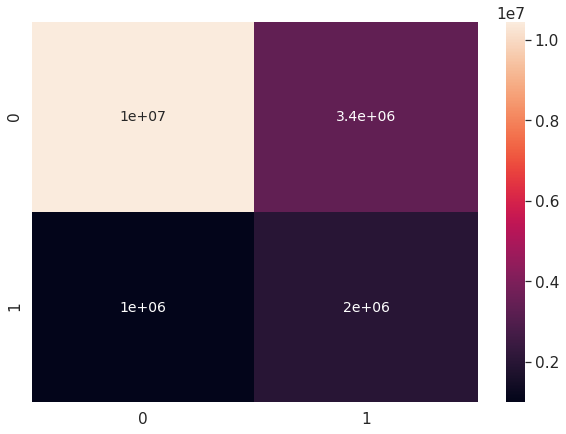

In [0]:
y_train_true = trainScoreAndLabels_pd["label"]
y_train_pred = trainScoreAndLabels_pd["raw"]
conf_mat_train = confusion_matrix(y_train_true, y_train_pred)

print("Train Set:")
print("Accuracy Score: ", accuracy_score(y_train_true, y_train_pred))
print("F1 Score: ", f1_score(y_train_true, y_train_pred))
print(classification_report(y_train_true, y_train_pred))


df_cm_train = pd.DataFrame(conf_mat_train, range(2), range(2))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm_train, annot=True, annot_kws={"size": 14}) # font size


# |TN FN|
# |FP TP|
plt.show()

#### Validation Performance

Validation Set:
Accuracy Score: 0.7385974781452548
F1 Score: 0.4497142142678527
 precision recall f1-score support

 0.0 0.89 0.77 0.83 5773111
 1.0 0.37 0.58 0.45 1298351

 accuracy 0.74 7071462
 macro avg 0.63 0.68 0.64 7071462
weighted avg 0.80 0.74 0.76 7071462

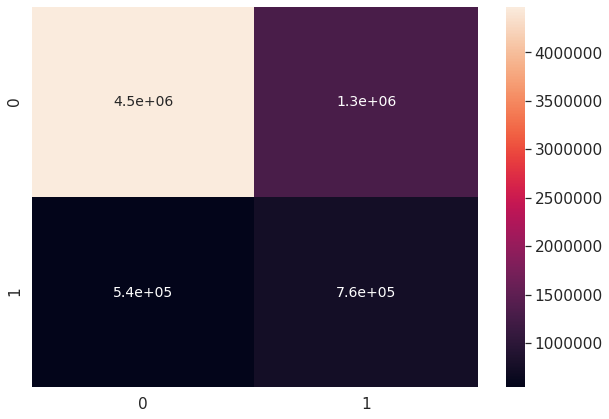

In [0]:
y_val_true = valScoreAndLabels_pd["label"]
y_val_pred = valScoreAndLabels_pd["raw"]
conf_mat_val = confusion_matrix(y_val_true, y_val_pred)

print("Validation Set:")
print("Accuracy Score: ", accuracy_score(y_val_true, y_val_pred))
print("F1 Score: ", f1_score(y_val_true, y_val_pred))
print(classification_report(y_val_true, y_val_pred))


df_cm_val = pd.DataFrame(conf_mat_val, range(2), range(2))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm_val, annot=True, annot_kws={"size": 14}) # font size


# |TN FN|
# |FP TP|
plt.show()

#### Test Performance

Test Set:
Accuracy Score: 0.7353786420585948
F1 Score: 0.44425091486055907
 precision recall f1-score support

 0.0 0.89 0.77 0.83 5916611
 1.0 0.36 0.57 0.44 1354174

 accuracy 0.74 7270785
 macro avg 0.63 0.67 0.64 7270785
weighted avg 0.79 0.74 0.76 7270785

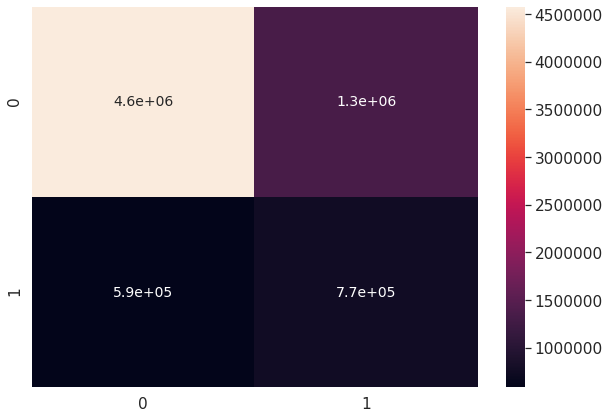

In [0]:
y_test_true = testScoreAndLabels_pd["label"]
y_test_pred = testScoreAndLabels_pd["raw"]
conf_mat_test = confusion_matrix(y_test_true, y_test_pred)

print("Test Set:")
print("Accuracy Score: ", accuracy_score(y_test_true, y_test_pred))
print("F1 Score: ", f1_score(y_test_true, y_test_pred))
print(classification_report(y_test_true, y_test_pred))


df_cm_test = pd.DataFrame(conf_mat_test, range(2), range(2))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm_test, annot=True, annot_kws={"size": 14}) # font size


# |TN FN|
# |FP TP|
plt.show()